In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [15]:
df = pd.read_csv('../eventDF.csv', index_col=0)
df.head(3)

,Old_ID,ID,AgeSex,Day,Went_From,Went_To,Status,Got_From,Got_At,From_geo,To_geo
0,5,0.0,50F,6,Hefei,Wuhan,0.0,NaN,NaN,"(31.85, 117.28)","(30.58, 114.27)"
1,5,0.0,50F,"(6, 6, 7)",NaN,NaN,1.0,NaN,Wuhan,NaN,NaN
2,5,0.0,50F,7,Wuhan,Hefei,1.0,NaN,NaN,"(30.58, 114.27)","(31.85, 117.28)"


In [16]:
df.ID.nunique()  # how many cases does this include

334

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1402 entries, 0 to 1401
Data columns (total 11 columns):
Old_ID       1402 non-null object
ID           1390 non-null float64
AgeSex       1402 non-null object
Day          1387 non-null object
Went_From    440 non-null object
Went_To      440 non-null object
Status       1388 non-null float64
Got_From     25 non-null object
Got_At       333 non-null object
From_geo     440 non-null object
To_geo       440 non-null object
dtypes: float64(2), object(9)
memory usage: 131.4+ KB


#### What was the mean status of people who were traveling with the disease?  So we're just looking at the 1's and 2's here.

In [18]:
sick_travels = df[(df.Status > 0) & (df.Status < 3) & (df.Went_From.notnull())]
sick_travels.groupby('ID').mean().mean()

Status    1.20116
dtype: float64

So about 20% of the people were traveling after they already had symptoms, while the other 80% had been infected but felt fine, or at least claimed so.  I grouped by patient and took the mean of the mean of each patient's travel statuses because many patients had multiple travel legs and I didn't want those patients' cases to carry more weight than patients with just one travel leg.

#### When did those 2's happen, compared to the 1's?

In [80]:
# Let's see what type of values we're dealing with here first
sick_travels.Day.values[100:130]

array(['18', '18', '6', '6', '18', '22', '22', '22', '22', '22', '22',
       '9', '19', '22', '20', '8', '21', '21', '13', '15', '15', '13',
       '13', '(14, 17)', '(14, 17)', '(0, 18, 19)', '19', '6', '18', '20'],
      dtype=object)

String floats mixed with string repr of 2- and 3-tuples:  It made life easier while not discarding any info, during data entry, but now needs a little regex to tidy up.

In [66]:
import re
def floatize(day):
    ''' Helper func to convert strings of numbers and strings of 2- and 3- tuples into single floats'''
    if day[0] != '(':
        return float(day)
    days = re.findall(r'[0-9]+', day)  ## convert """  '(20,24,25)'  """ into """  ['20', '24', '25']  """
    if len(days) == 3:
        return float(days[1])  # that's the best-guess day in the 3-tuples
    if len(days) == 2:
        return sum(float(d) for d in days) / 2
    return np.nan

In [77]:
sick_travels['Float_Day'] = sick_travels.Day.apply(floatize)

/Users/ethanhaley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [78]:
sick_travels.head()

,Old_ID,ID,AgeSex,Day,Went_From,Went_To,Status,Got_From,Got_At,From_geo,To_geo,Float_Day
2,5,0.0,50F,7,Wuhan,Hefei,1.0,NaN,NaN,"(30.58, 114.27)","(31.85, 117.28)",7.0
10,1,3.0,30M,17,Wuhan,Chaohu,1.0,NaN,NaN,"(30.58, 114.27)","(31.632, 117.882)",17.0
16,2,4.0,47M,10,Luzhou,Hefei,1.0,NaN,NaN,"(28.88, 105.38)","(31.85, 117.28)",10.0
22,3,5.0,49M,10,Yinzhou,Hefei,1.0,NaN,NaN,"(29.808, 121.561)","(31.85, 117.28)",10.0
27,10,6.0,30M,21,Wuhan,Hefei,2.0,NaN,NaN,"(30.58, 114.27)","(31.85, 117.28)",21.0


In [81]:
# how many legs of travel, on avg, does a patient have here?
len(sick_travels) / sick_travels.ID.nunique()

1.3132911392405062

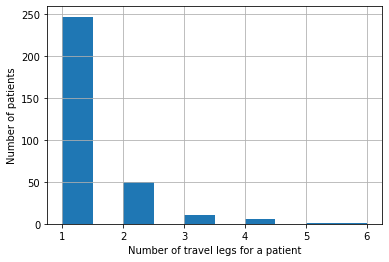

In [83]:
sick_travels.groupby('ID').size().hist()
plt.xlabel('Number of travel legs for a patient')
plt.ylabel('Number of patients');

So let's just look at each travel leg as a point on its own, regardless of whether the traveler had 4 points or 1.

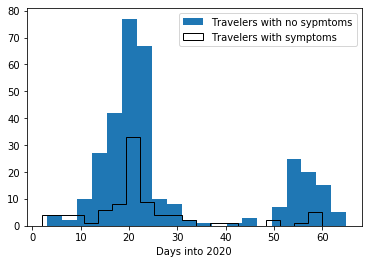

In [108]:
asymp = sick_travels[sick_travels.Status == 1]
symp = sick_travels[sick_travels.Status == 2]
asymp['Float_Day'].hist(bins=20, label='Travelers with no sypmtoms')
symp['Float_Day'].hist(histtype='step', color='k', bins=20, label='Travelers with symptoms')
plt.legend()
plt.grid(False)
plt.xlabel('Days into 2020');


In [109]:
print('===> mean day of travel for patients with no symptoms: ' + str(asymp['Float_Day'].mean()))
print('...and for patients with symptoms: ' + str(symp['Float_Day'].mean()))
      

===> mean day of travel for patients with no symptoms: 28.024539877300615
...and for patients with symptoms: 23.06179775280899


It looks as though during February, people were becoming aware enough of the contagiousness of cov-19 that they were not traveling as much once they had symptoms (or they weren't being allowed to).  Also of note are the peaks in both types of travelers just after 20 January.  Partly it's just a function of the fact that the virus was spreading rapidly in China in mid-January, so much so that China shut down travel to and from Wuhan on January 22nd, leading to the sudden dropoff in sick travelers on the chart.  But the chart also suggests that people caught wind of the imminent Wuhan shutdown and made a last-ditch effort, knowingly sick or not, to flee to their hometowns before it was too late.  The evidence for that lies in the ratio of symptomatic travelers to asymptomatic ones in the prior week, where the ratio appears to be less than 1 to 4, compared to the ratio on 20-21 Jan, where it spikes up to maybe 3 to 7. Let's see the actual data:

In [110]:
jan13to19symp = symp[(symp.Float_Day >= 13) & (symp.Float_Day < 20)]
jan13to19asymp = asymp[(asymp.Float_Day >= 13) & (asymp.Float_Day < 20)]
jan20to21symp = symp[(symp.Float_Day >= 20) & (symp.Float_Day < 22)]
jan20to21asymp = asymp[(asymp.Float_Day >= 20) & (asymp.Float_Day < 22)]

print('The proportion of sick travelers who were symptomatic in the week before 20 Jan:')
print(np.round(len(jan13to19symp) / (len(jan13to19asymp) + len(jan13to19symp)), 2))
print()
print('The proportion of sick travelers who were symptomatic on 20-21 Jan:')
print(np.round(len(jan20to21symp) / (len(jan20to21asymp) + len(jan20to21symp)), 2))

The proportion of sick travelers who were symptomatic in the week before 20 Jan:
0.13

The proportion of sick travelers who were symptomatic on 20-21 Jan:
0.28


Just curious how these numbers change if the approximated days of travel aren't included:

In [115]:
approx = sick_travels.Day.str.startswith('(')
not_approx = sick_travels[~approx]
not_approx['Int_Day'] = [int(d) for d in not_approx.Day]

exact_asymp = not_approx[not_approx.Status == 1]
exact_symp = not_approx[not_approx.Status == 2]
print('===> mean day of travel for patients with no symptoms: ' + str(exact_asymp['Int_Day'].mean()))
print('...and for patients with symptoms: ' + str(exact_symp['Int_Day'].mean()))
print('(vs. 28.02 and 23.06 with approximate dates included)')

===> mean day of travel for patients with no symptoms: 28.414790996784564
...and for patients with symptoms: 22.65
(vs. 28.02 and 23.06 with approximate dates included)


/Users/ethanhaley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### We should test the null hypothesis on those numbers

First check the null hypothesis that sick people with symptoms continued to travel just as much as sick people without symptoms, throughout the travel period covered by the data here.

Check 10,000 random permutations of the travel events to see how likely the null hypothesis is.

In [147]:
n = len(asymp)
days = sick_travels.Float_Day.values
# take 10000 randomly permuted split samples of the days and see how many have > 5 days difference between the sample means
diffs = []
for _ in range(10000):
    np.random.shuffle(days)
    diffs.append(np.mean(days[:n]) - np.mean(days[n:]))

print('p-value for the null hypothesis, given the difference between the means: ')
observed_diff = 28.02 - 23.06
print(sum(np.array(diffs) >= observed_diff) / 10000)

p-value for the null hypothesis, given the difference between the means: 
0.0023


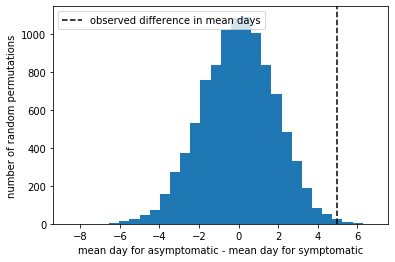

In [148]:
plt.hist(diffs, bins=30)
plt.axvline(observed_diff, linestyle='--', color='k', label='observed difference in mean days')
plt.legend()
plt.xlabel('mean day for asymptomatic - mean day for symptomatic')
plt.ylabel('number of random permutations');

Unless someone demands an unusually high significance level for this test, that p-value is small enough to reject the null hypothesis and accept the alternative, which is that people with symptoms were either intentionally avoiding travel, or perhaps being required to do so, as time increased.  Nevertheless, amidst that overall trend, there's an opposing trend on a smaller scale, where the proportion of sick travelers who were symptomatic rose from 0.13 in the week before 20 Jan to 0.28 on 20-21 Jan, probably due to the impending Wuhan lockdown.  

Even ignoring the more general trend, which would suggest this rise in proportion is unlikely, let's see how unlikely it is.  The null hypothesis will be that the sick travelers on these 9 days are randomly distributed, such that the increase in proportions of symptomatic travelers has a true mean of 0 and a standard deviation large enough that the one we actually see, 0.15, is not statistically significant.  I'll start by claiming that any increase beyond 1.64 standard devs is enough to reject that null hypothesis, since less than 5% of random permutations should show that large of an increase.

In [153]:
n_symp = len(jan13to19symp) + len(jan20to21symp)  # total number of symptomatic in these 9 days
n_asymp = len(jan13to19asymp) + len(jan20to21asymp)  # total number of asymptomatic in these 9 days
print(f'Total number of travel legs for 13-21 Jan:  {n_symp + n_asymp}')
n_13_to_19 = len(jan13to19symp) + len(jan13to19asymp)  # all travels jan.13-19
n_20_to_21 = len(jan20to21symp) + len(jan20to21asymp)  # all travels jan.20-21
print(f'{n_13_to_19} of them Jan.13-19 and {n_20_to_21} of them Jan.20-21')

Total number of travel legs for 13-21 Jan:  179
110 of them Jan.13-19 and 69 of them Jan.20-21


In [154]:
had_symp = np.array([0] * n_asymp + [1] * n_symp)
n_trials = 10000
diffs = np.empty(n_trials)
for i in range(n_trials):
    had_symp = np.random.permutation(had_symp) # shuffle them
    post = sum(had_symp[n_13_to_19:]) / n_20_to_21  # proportion symptomatic for 2nd period
    pre = sum(had_symp[:n_13_to_19]) / n_13_to_19  # proportion symptomatic for 1st period
    diffs[i] = post - pre   # the statistic being calculated and tested

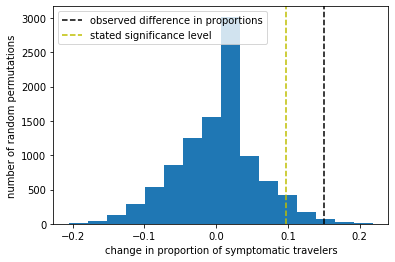

In [159]:
observed_diff = 0.28 - 0.13   # the actual increase in proportion from the 1st period to the second
plt.hist(diffs, bins=16)  # higher numbers of bins had empty bins that were confusing
plt.axvline(observed_diff, linestyle='--', color='k', label='observed difference in proportions')
plt.axvline(np.std(diffs) * 1.64, linestyle='--', color='y', label='stated significance level')
plt.legend()
plt.xlabel('change in proportion of symptomatic travelers')
plt.ylabel('number of random permutations');

Since the observed difference is to the right of the stated significance level, we know the p-value is less than 0.05, we can reject the null hypothesis, and we can be confident that there's a reason more people are traveling when they know they're sick on 20-21 Jan.   The part of this analysis that's somewhat questionable is that it smacks of the "Texas Sharpshooter" phenomenon, since I began by focusing on a specific part of the data that seemed interesting, and then I drew a circle around the perfect dates that perhaps minimized p-values for the null hypothesis.  What I would say in my defense is that the dates before the selected ones contain very few cases, and indeed the symptomatic travelers at that point most likely had no idea their symptoms might be from covid-19 (The Chinese government only announced the existence of the new coronavirus on 7 Jan).  Also in my defense, the most likely underlying cause for the data I circled--the Wuhan shutdown--draws its own endpoint in time, on 22 January.  And finally, as I pointed out, this analyzed trend runs counter to the overall trend, which makes it inherently less likely and more worth exploring.